# Análise Exploratória de Dados de TDM

## Utils

Aqui armazenamos as funções utilizadas nas análises dos dados.

In [40]:
import string
import matplotlib.pyplot as plt
import pandas as pd

def plot_data(df_list:list[pd.DataFrame], legend:list, y_data:list, x_data:string, h_dist:bool = True):
    
    if h_dist:
        plt.figure(figsize=(20, 10))
        ax_n = len(y_data)
        for y in y_data:
            index = y_data.index(y)
            plt.subplot(1,ax_n,index+1)
            for df in df_list:
                plt.plot(df[x_data], df[y], "+")
                plt.ylabel(y)
                plt.xlabel(x_data)
                plt.legend(legend)
    else:
        plt.figure(figsize=(10, 20))
        ax_n = len(y_data)
        for y in y_data:
            index = y_data.index(y)
            plt.subplot(ax_n,1,index+1)
            for df in df_list:
                plt.plot(df[x_data], df[y], "+")
                plt.ylabel(y)
                plt.xlabel(x_data)
                plt.legend(legend)
    
    
    plt.show()

In [41]:
import pandas as pd
from src.tracking_data_message.tracking_data_message import *


def filter_raw_data(df_raw: pd.DataFrame, df_fit=None):
    if df_fit is None:
        _, _, df_fit = fit_radec_tdm_data(df_raw, 3)
    std_ra = df_fit.describe().loc["std", "Desvio RA (%)"]
    mean_ra = df_fit.describe().loc["mean", "Desvio RA (%)"]
    third_quarter_ra = df_fit.describe().loc["75%", "Desvio RA (%)"]
    std_dec = df_fit.describe().loc["std", "Desvio DEC (%)"]
    mean_dec = df_fit.describe().loc["mean", "Desvio DEC (%)"]
    third_quarter_dec = df_fit.describe().loc["75%", "Desvio DEC (%)"]
    # filter_bool = (abs(df_fit["Desvio RA (%)"] - mean_ra) < 1.0 * std_ra) & (
    #     abs(df_fit["Desvio DEC (%)"] - mean_dec) < 1.0 * std_dec
    # )
    filter_bool = (df_fit['Desvio RA (%)'] < third_quarter_ra) & (df_fit['Desvio DEC (%)'] < third_quarter_dec)
    # filter_bool = (df_fit['Desvio RA (deg)'] < 0.25) & (df_fit['Desvio DEC (deg)'] < 0.25)
    time_filtered = df_fit[filter_bool]["Tempo[s]"]
    return df_raw.loc[df_raw["Tempo[s]"].isin(time_filtered)]

In [42]:
import pandas as pd
import numpy as np

def compare_radec_data(poly_ra, poly_dec, df_referencia: pd.DataFrame, x_max: float):

    desvio_ra = []
    desvio_dec = []
    desvio_ra_deg = []
    desvio_dec_deg = []

    for index, row in df_referencia.iterrows():
        x = row["Tempo[s]"]
        if x <= x_max:
            ra = row["RA[deg]"]
            dec = row["DEC[deg]"]
            desvio_ra_deg.append(np.abs(ra - poly_ra(x)))
            desvio_dec_deg.append(np.abs(dec - poly_dec(x)))
            desvio_ra.append(100 * np.abs((ra - poly_ra(x)) / ra))
            desvio_dec.append(100 * np.abs((dec - poly_dec(x)) / dec))

    dados_fit = {
        "Desvio RA (%)": desvio_ra,
        "Desvio DEC (%)": desvio_dec,
        "Desvio RA (deg)": desvio_ra_deg,
        "Desvio DEC (deg)": desvio_dec_deg,
    }

    df_fit = pd.DataFrame(data=dados_fit)

    # Desvios para RA
    median_ra = np.median(df_fit["Desvio RA (%)"])
    mean_ra = np.mean(df_fit["Desvio RA (%)"])
    std_ra = np.std(df_fit["Desvio RA (%)"])

    # Desvios para DEC
    median_dec = np.median(df_fit["Desvio DEC (%)"])
    mean_dec = np.mean(df_fit["Desvio DEC (%)"])
    std_dec = np.std(df_fit["Desvio DEC (%)"])

    dados_stats = {
        "Média RA (%)": mean_ra,
        "Média DEC (%)": mean_dec,
        "Mediana RA (%)": median_ra,
        "Mediana DEC (%)": median_dec,
        "Desvio Padrão RA (%)": std_ra,
        "Desvio Padrão DEC (%)": std_dec,
        "Máximo erro RA (%)": df_fit["Desvio RA (%)"].max(),
        "Máximo erro RA (deg)": df_fit["Desvio RA (deg)"].max(),
        "Máximo erro DEC (%)": df_fit["Desvio DEC (%)"].max(),
        "Máximo erro DEC (deg)": df_fit["Desvio DEC (deg)"].max(),
    }
    df = pd.DataFrame(data=dados_stats, index=[""])
    return df

In [43]:
from src.models.observatory import Observatory
from src.models.observation import Observation
from src.orbit.orbit_determination import *

class TLE:
    def __init__(
        self, a: float, i: float, ra: float, e: float, w: float, theta: float
    ) -> None:
        self.a = a
        self.i = i
        self.ra = ra
        self.e = e
        self.w = w
        self.theta = theta
    
    def to_list(self):
        return [self.a,self.i,self.ra,self.e,self.w]



def get_observations(tdm: pd.DataFrame, observatory: Observatory, last_position: int) -> list[Observation]:
    # Posições Analisadas:
    initial = 0
    middle = int(last_position / 2)
    end = last_position - 1

    observations = []

    for i in [initial, middle, end]:
        ra = tdm["RA[deg]"].iloc[i]
        dec = tdm["DEC[deg]"].iloc[i]
        time_utc = tdm["Tempo (UTC)"].iloc[i]
        obs = Observation(ra, dec, time_utc)
        obs.observatory = observatory
        observations.append(obs)
    return observations


def get_state_vector(
    observations: list[Observation], observatory: Observatory
) -> tuple[Vector, Vector]:
    # Posições Analisadas:
    RAs = [observations[0].ra, observations[1].ra, observations[2].ra]
    DECs = [observations[0].dec, observations[1].dec, observations[2].dec]
    local_sidereal_time = [
        observations[0].sidereal_time,
        observations[1].sidereal_time,
        observations[2].sidereal_time,
    ]
    t = [
        observations[0].time_seconds,
        observations[1].time_seconds,
        observations[2].time_seconds,
    ]
    # Estimativa inicial do vetor de estado do objeto (r2,v2):
    r2, v2 = r2v2_from_angles_only_gauss(
        latitude_geodetic=observatory.latitude_geodetic,
        altitude=observatory.altitude,
        local_sidereal_times=local_sidereal_time,
        RAs=RAs,
        DECs=DECs,
        times=t,
    )
    return (r2, v2)



def get_orbital_parameters(r: Vector, v: Vector) -> TLE:

    # Obtenção dos elementos orbitais:
    h, i, ra, e, w, theta = classic_orbital_elements_from_rv(r, v)

    # Obtenção do semi-eixo maior:
    a = semimajor_axis_from_he(h, e)

    return TLE(a, i, ra, e, w, theta)

In [44]:
def get_iod_multiple_radec(tdm: pd.DataFrame, observatory: Observatory) -> pd.DataFrame:
    dt = []
    a = []
    i = []
    omega = []
    w = []
    e = []
    for index in range(1, len(tdm["Tempo[s]"])):
        try:
            obs, _, _, tle = get_iod(tdm, observatory, index+1)
            a.append(tle.a)
            e.append(tle.e)
            omega.append(tle.ra)
            w.append(tle.w)
            i.append(tle.i)
            dt.append(obs[2].time_seconds - obs[0].time_seconds)
        except:
            continue
    data = {"a": a, "e": e, "omega": omega, "w": w, "i": i, "dt": dt}
    df = pd.DataFrame(data=data)
    # Filtro de Outliers:
    df.dropna(inplace=True)
    df.where((df["e"] < 1.0), inplace=True)
    return df


def get_iod(tdm: pd.DataFrame, observatory: Observatory, index: int = None):
    index = len(tdm["Tempo[s]"]) if index is None else index
    obs = get_observations(tdm, observatory, index)
    r, v = get_state_vector(obs, observatory)
    tle = get_orbital_parameters(r, v)
    return (obs, r, v, tle)

## Análise de Impacto do Threshold

Para essa análise, será explorado a sensibilidade com relação ao $\textit{threshold}$ adotado na detecção das $\textit{streaks}$ em cada uma das imagens. Ainda, nesta análise, alterou-se o parâmetro multiplicador do FOV para 1.5 e a área de procura de estrelas no Gaia passou a ser retangular.

In [45]:
from src.tracking_data_message.tracking_data_message import *

# Importação dos dados brutos do TDM
tdm_aldoria_raw = read_tdm("Dados\\TDM\\TDM_7646.txt")
tdm_30_raw = read_tdm("Dados\\TDM\\Threshold\\TDM-Saipher-30.txt")
tdm_25_raw = read_tdm("Dados\\TDM\\Threshold\\TDM-Saipher-25.txt")

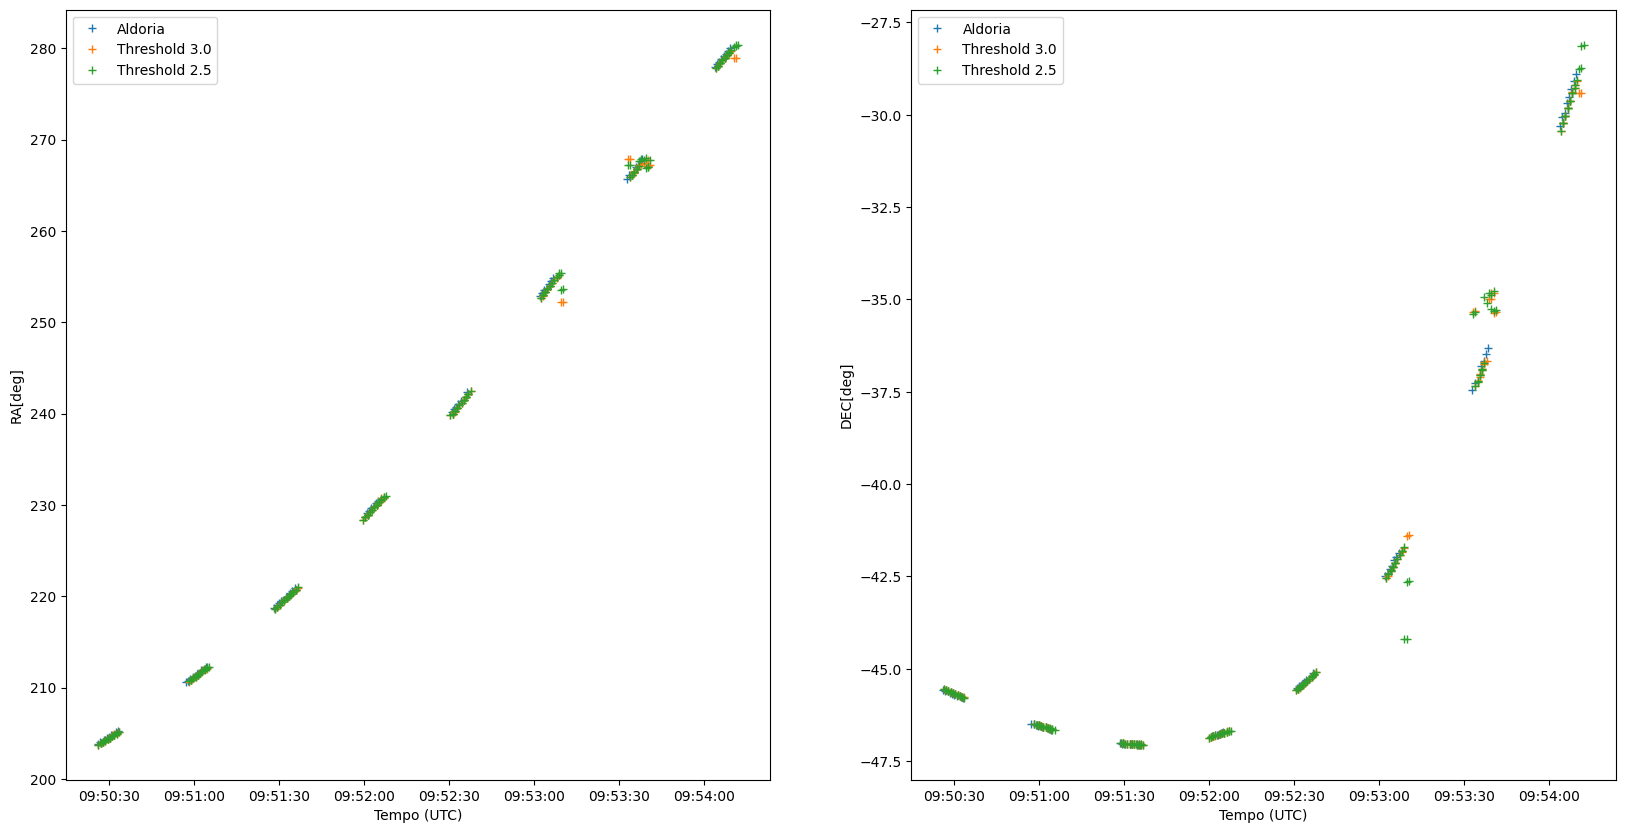

In [46]:
plot_data(
    df_list=[tdm_aldoria_raw, tdm_30_raw, tdm_25_raw],
    legend=["Aldoria", "Threshold 3.0", "Threshold 2.5"],
    y_data=["RA[deg]", "DEC[deg]"],
    x_data='Tempo (UTC)',
)

### Análise de Outliers

Para removermos os $\textit{outliers}$ dos dados, vamos considerar o seguinte roteiro:
* Interpolar polinomialmente os dados do TDM gerado através de uma curva $p(x) = ax^3+bx^2+cx+d$
* Aplicar um filtro nos dados a partir do polinômio obtido, sendo considerados um dentre os 3 filtros seguintes:
    * A diferença entre o desvio de RA e DEC para $x$ e a média dos respectivos desvios é menor do que os respectivos desvios padrão
    * O desvio de RA e DEC para $x$ estão entre os $75%$ menores
    * O desvio absoluto de RA e DEC de $x$ é menor do que $0,25\degree$ 

In [47]:
# Interpolação inicial dos dados brutos:
_, _, tdm_30_fit_raw = fit_radec_tdm_data(tdm_30_raw, 3)
_, _, tdm_25_fit_raw = fit_radec_tdm_data(tdm_25_raw, 3)
_, _, tdm_aldoria_fit_raw = fit_radec_tdm_data(tdm_aldoria_raw, 3)

# Filtragem dos dados com base na interpolação inicial de um polinômio de grau 3:
tdm_30_filtered = filter_raw_data(df_raw=tdm_30_raw,df_fit=tdm_30_fit_raw)
tdm_25_filtered = filter_raw_data(df_raw=tdm_25_raw,df_fit=tdm_25_fit_raw)

# Interpolação com os dados fltrados:
poly_ra_30, poly_dec_30, tdm_30_fit = fit_radec_tdm_data(tdm_30_filtered, 3)
poly_ra_25, poly_dec_25, tdm_25_fit = fit_radec_tdm_data(tdm_25_filtered, 3)


### Comparação com os dados da Aldoria

Após a filtragem dos dados e nova interpolação, podemos plotar novamente para comparação com os dados da Aldoria.

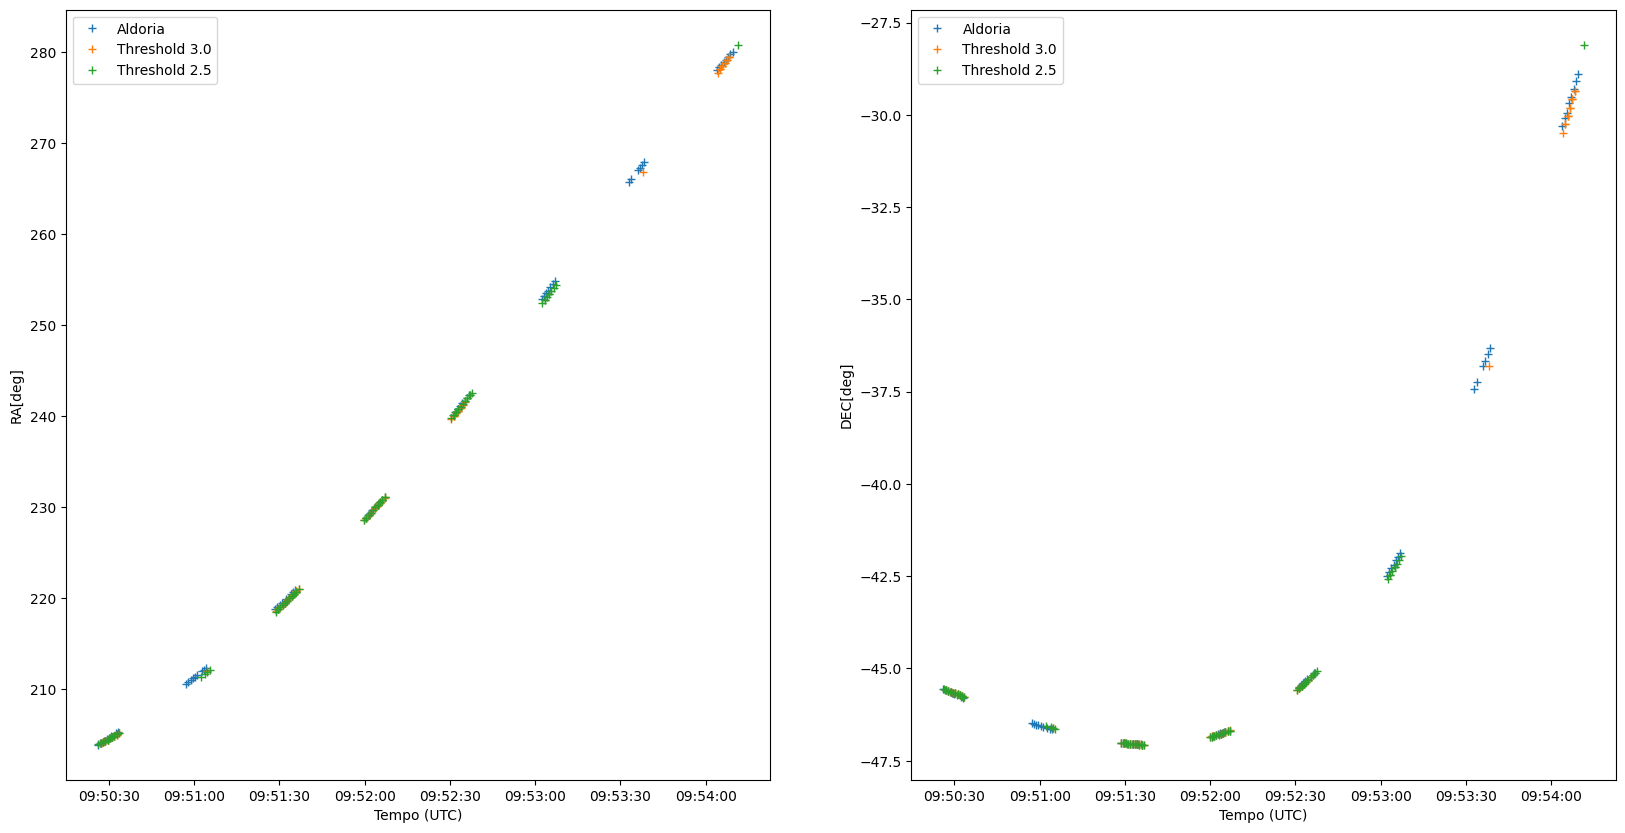

In [48]:
plot_data(
    df_list=[tdm_aldoria_raw, tdm_30_fit, tdm_25_fit],
    legend=["Aldoria", "Threshold 3.0", "Threshold 2.5"],
    y_data=["RA[deg]", "DEC[deg]"],
    x_data="Tempo (UTC)",
)

Analisando comparativamente os dados interpolados com os dados da Aldoria originais, temos:

In [49]:
# Comparação com os dados interpolados com os valores do TDM da Aldoria
stats_30 = compare_radec_data(poly_ra_30,poly_dec_30,tdm_aldoria_raw,x_max=tdm_30_filtered['Tempo[s]'].max())
stats_25 = compare_radec_data(poly_ra_25,poly_dec_25,tdm_aldoria_raw,x_max=tdm_25_filtered['Tempo[s]'].max())

# Concatenação dos resultados:
stats = pd.concat([stats_30,stats_25],ignore_index=True)
stats.index = ['Threshold 3.0', 'Threshold 2.5']
stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro RA (deg),Máximo erro DEC (%),Máximo erro DEC (deg)
Threshold 3.0,0.172771,0.266041,0.135934,0.082555,0.105180,0.345839,0.394193,1.048835,1.103076,0.410903
Threshold 2.5,0.143772,0.190535,0.132197,0.085388,0.096027,0.227073,0.316141,0.841162,0.780421,0.290712


### Determinação de Órbita

Agora, a partir dos TDM tratados podemos obter uma estimativa preliminar das órbitas.

In [50]:
from src.orbit.orbit_determination import *

# Dados do Observatório da Aldoria:
latitude = -30.5262693  # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799  # [deg]
altitude = 2180e-3  # [km]

observatory = Observatory(
    longitude=longitude, latitude=latitude, altitude=altitude
)

# Observações:
tdm_aldoria_raw = read_tdm(filename="Dados\\TDM\\TDM_7646.txt")
tdm_saipher_30_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-30.txt")
tdm_saipher_25_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-25.txt")

# Filtragem dos dados:
tdm_saipher_30_filtered = filter_raw_data(df_raw=tdm_saipher_30_raw)
tdm_saipher_25_filtered = filter_raw_data(df_raw=tdm_saipher_25_raw)

# Ajuste polinomial:
_,_,tdm_saipher_30_fit = fit_radec_tdm_data(raw_data=tdm_saipher_30_filtered,poly_degree=3)
_,_,tdm_saipher_25_fit = fit_radec_tdm_data(raw_data=tdm_saipher_25_filtered,poly_degree=3)
_,_,tdm_aldoria_fit = fit_radec_tdm_data(raw_data=tdm_aldoria_raw,poly_degree=3)

# Determinação Inicial de Órbita:
_,_,_,tle_aldoria_raw = get_iod(tdm_aldoria_raw,observatory)
_,_,_,tle_saipher_30_raw = get_iod(tdm_saipher_30_raw,observatory)
_,_,_,tle_saipher_25_raw = get_iod(tdm_saipher_25_raw,observatory)
_,_,_,tle_saipher_30_filtered = get_iod(tdm_saipher_30_filtered,observatory)
_,_,_,tle_saipher_25_filtered = get_iod(tdm_saipher_25_filtered,observatory)
_,_,_,tle_saipher_30_fit = get_iod(tdm_saipher_30_fit,observatory)
_,_,_,tle_saipher_25_fit = get_iod(tdm_saipher_25_fit,observatory)
_,_,_,tle_aldoria_fit = get_iod(tdm_aldoria_fit,observatory)

# Dados do TLE
# 1 07646U 75010A   23115.56559076 -.00000125  00000-0  12485-4 0  9994
# 2 07646  49.8253 318.3095 0205748 228.5962 129.7086 13.82317979435651
e_tle = 0.02057480
i_tle = 49.8253
ra_tle = 318.3095
w_tle = 228.5962
a_tle = 7333.814
m_tle = 129.7086


# Resultados:
results = {
    "Aldoria - Raw": tle_aldoria_raw.to_list(),
    "Aldoria - Fit": tle_aldoria_fit.to_list(),
    "Saipher 3.0 - Raw": tle_saipher_30_raw.to_list(),
    "Saipher 3.0 - Filtered": tle_saipher_30_filtered.to_list(),
    "Saipher 3.0 - Fit": tle_saipher_30_fit.to_list(),
    "Saipher 2.5 - Raw": tle_saipher_25_raw.to_list(),
    "Saipher 2.5 - Filtered": tle_saipher_25_filtered.to_list(),
    "Saipher 2.5 - Fit": tle_saipher_25_fit.to_list(),    
    "TLE": [a_tle, i_tle, ra_tle, e_tle, w_tle],
}

orbital_parameters_df = pd.DataFrame(
    index=[
        "Semi-eixo maior [km]",
        "Inclinação [°]",
        "Ascensão reta do nó de ascensão [°]",
        "Ecentricidade [-]",
        "Argumento do Pergieu [°]",
    ],
    data=results,
)

# print("Vetores de Estado:")
# print(
#     f"v2_aldoria = {round(v2_aldoria.x,4)}I + ({round(v2_aldoria.y,4)})J + ({round(v2_aldoria.z,4)})K"
# )
# print(
#     f"v2_saipher = {round(v2_saipher_30.x,4)}I + ({round(v2_saipher_30.y,4)})J + ({round(v2_saipher_30.z,4)})K     (ex = {round(abs(100*(v2_saipher_30.x-v2_aldoria.x)/v2_aldoria.x),4)}% ey = {round(abs(100*(v2_saipher_30.y-v2_aldoria.y)/v2_aldoria.y),4)}% ez = {round(abs(100*(v2_saipher_30.z-v2_aldoria.z)/v2_aldoria.z),4)}%)"
# )
# print(
#     f"v2_saipher = {round(v2_saipher_25.x,4)}I + ({round(v2_saipher_25.y,4)})J + ({round(v2_saipher_25.z,4)})K     (ex = {round(abs(100*(v2_saipher_25.x-v2_aldoria.x)/v2_aldoria.x),4)}% ey = {round(abs(100*(v2_saipher_25.y-v2_aldoria.y)/v2_aldoria.y),4)}% ez = {round(abs(100*(v2_saipher_25.z-v2_aldoria.z)/v2_aldoria.z),4)}%)"
# )
# print(
#     f"r2_aldoria = {round(r2_aldoria.x,4)}I + ({round(r2_aldoria.y,4)})J + ({round(r2_aldoria.z,4)})K"
# )
# print(
#     f"r2_saipher = {round(r2_saipher_30.x,4)}I + ({round(r2_saipher_30.y,4)})J + ({round(r2_saipher_30.z,4)})K     (ex = {round(abs(100*(r2_saipher_30.x-r2_aldoria.x)/r2_aldoria.x),4)}% ey = {round(abs(100*(r2_saipher_30.y-r2_aldoria.y)/r2_aldoria.y),4)}% ez = {round(abs(100*(r2_saipher_30.z-r2_aldoria.z)/r2_aldoria.z),4)}%)"
# )
# print(
#     f"r2_saipher = {round(r2_saipher_25.x,4)}I + ({round(r2_saipher_25.y,4)})J + ({round(r2_saipher_25.z,4)})K     (ex = {round(abs(100*(r2_saipher_25.x-r2_aldoria.x)/r2_aldoria.x),4)}% ey = {round(abs(100*(r2_saipher_25.y-r2_aldoria.y)/r2_aldoria.y),4)}% ez = {round(abs(100*(r2_saipher_25.z-r2_aldoria.z)/r2_aldoria.z),4)}%)"
# )
print("\nParâmetros Orbitais:")
orbital_parameters_df


Parâmetros Orbitais:


,Aldoria - Raw,Aldoria - Fit,Saipher 3.0 - Raw,Saipher 3.0 - Filtered,Saipher 3.0 - Fit,Saipher 2.5 - Raw,Saipher 2.5 - Filtered,Saipher 2.5 - Fit,TLE
Semi-eixo maior [km],7363.593056,5912.820741,5753.553363,7592.066637,7382.581884,4860.576055,4843.477247,5307.941808,7333.814000
Inclinação [°],49.774642,49.517329,49.679590,49.791446,49.763857,49.388186,49.387707,49.477014,49.825300
Ascensão reta do nó de ascensão [°],318.718731,319.209851,318.975154,318.679840,318.734533,319.541812,319.544840,319.352418,318.309500
Ecentricidade [-],0.025400,0.219320,0.255476,0.042773,0.026186,0.452533,0.456816,0.342742,0.020575
Argumento do Pergieu [°],235.640729,137.644483,139.804069,274.721498,240.556681,134.841158,134.945576,135.381936,228.596200


Analisando o comportamento considerando os múltiplos valores de RA e DEC, temos:

In [51]:
# Dados do Observatório da Aldoria:
latitude = -30.5262693  # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799  # [deg]
altitude = 2180e-3  # [km]

observatory = Observatory(
    longitude=longitude, latitude=latitude, altitude=altitude
)

# Observações:
tdm_aldoria_raw = read_tdm(filename="Dados\\TDM\\TDM_7646.txt")
tdm_saipher_30_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-30.txt")
tdm_saipher_25_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-25.txt")

# Filtragem dos dados:
tdm_saipher_30_filtered = filter_raw_data(df_raw=tdm_saipher_30_raw)
tdm_saipher_25_filtered = filter_raw_data(df_raw=tdm_saipher_25_raw)

# Ajuste polinomial:
_,_,tdm_saipher_30_fit = fit_radec_tdm_data(raw_data=tdm_saipher_30_filtered,poly_degree=3)
_,_,tdm_saipher_25_fit = fit_radec_tdm_data(raw_data=tdm_saipher_25_filtered,poly_degree=3)

# Obtenção dos dados:
tles_aldoria = get_iod_multiple_radec(tdm_aldoria_raw, observatory)
tles_saipher_30_filtered = get_iod_multiple_radec(tdm_saipher_30_filtered, observatory)
tles_saipher_25_filtered = get_iod_multiple_radec(tdm_saipher_25_filtered, observatory)
tles_saipher_30_fit = get_iod_multiple_radec(tdm_saipher_30_fit, observatory)
tles_saipher_25_fit = get_iod_multiple_radec(tdm_saipher_25_fit, observatory)

c:\Users\rafael.facchin\OneDrive - Saipher ATC\Referências\spacepykit\src\common\vector.py:21: RuntimeWarning: invalid value encountered in scalar divide
  self._theta_x = np.arccos(x/self._magnitude)
c:\Users\rafael.facchin\OneDrive - Saipher ATC\Referências\spacepykit\src\common\vector.py:22: RuntimeWarning: invalid value encountered in scalar divide
  self._theta_y = np.arccos(y/self._magnitude)
c:\Users\rafael.facchin\OneDrive - Saipher ATC\Referências\spacepykit\src\common\vector.py:23: RuntimeWarning: invalid value encountered in scalar divide
  self._theta_z = np.arccos(z/self._magnitude)
c:\Users\rafael.facchin\OneDrive - Saipher ATC\Referências\spacepykit\src\orbit\orbit_determination.py:83: RuntimeWarning: invalid value encountered in scalar divide
  A = (-D[0][1]*(tau_3/tau) + D[1][1] + D[2][1]*(tau_1/tau))/D0
c:\Users\rafael.facchin\OneDrive - Saipher ATC\Referências\spacepykit\src\orbit\orbit_determination.py:84: RuntimeWarning: divide by zero encountered in scalar divide


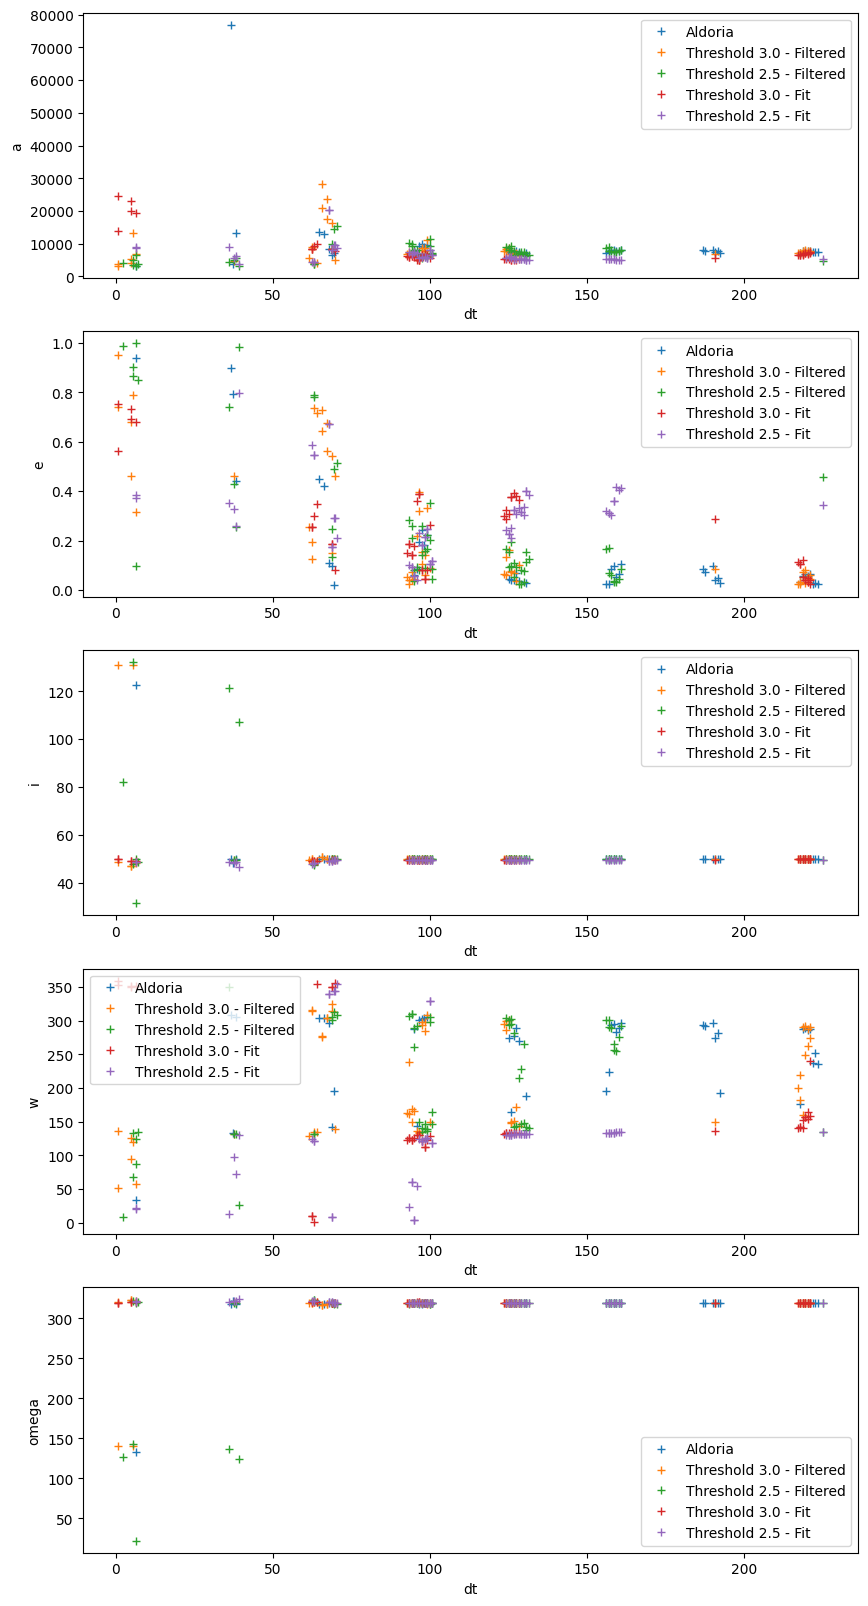

In [52]:
# Plot dos Resultados:
plot_data(
    df_list=[tles_aldoria, tles_saipher_30_filtered, tles_saipher_25_filtered, tles_saipher_30_fit, tles_saipher_25_fit],
    legend=["Aldoria", "Threshold 3.0 - Filtered", "Threshold 2.5 - Filtered", "Threshold 3.0 - Fit", "Threshold 2.5 - Fit"],
    y_data=["a", "e","i","w","omega"],
    x_data="dt",
    h_dist=False
)


Por fim, após análise dos filtros aplicados, optou-se por utilizar o filtro:

$|e_{RA}-\mu_{RA}|<\sigma_{RA} ~ \&\& ~ |e_{DEC}-\mu_{DEC}|<\sigma_{DEC}$

Uma vez que foi o que apresentou melhores dados estatísticos.